In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skm
import statsmodels.api as sm
import math
from scipy.stats import norm

#df = pd.DataFrame(pd.read_pickle("../data/pricespaths.pickle")).T
df = pd.DataFrame(pd.read_csv("../data/training_pricepaths.csv"))

In [3]:
df.head()


,Unnamed: 0,underlying,call65,call70,call75,call80,call85,call90,call95,call100,...,put90,put95,put100,put105,put110,put115,put120,put125,put130,put135
0,0,100.000000,35.436537,30.436449,25.465460,20.544501,15.718957,11.091298,6.883928,3.493461,...,1.091298,1.883928,3.493461,6.333979,10.375479,15.090290,20.025352,25.011182,30.008593,35.010526
1,1,99.703351,35.117638,30.116325,25.143759,20.221087,15.395046,10.773197,6.591873,3.268877,...,1.069846,1.888522,3.565526,6.509131,10.632709,15.380026,20.322307,25.309459,30.307651,35.311125
2,2,99.781739,35.246585,30.252950,25.291467,20.385660,15.585513,11.000335,6.856841,3.536347,...,1.218595,2.075101,3.754608,6.627924,10.649909,15.334966,20.254847,25.235405,30.231430,35.233703
3,3,99.989922,35.412877,30.423416,25.464844,20.560375,15.759372,11.169538,7.013417,3.664809,...,1.179616,2.023495,3.674888,6.502648,10.479730,15.139596,20.050467,25.028339,30.023364,35.024824
4,4,99.348765,34.765348,29.783212,24.834189,19.944124,15.167839,10.623611,6.550014,3.329964,...,1.274847,2.201250,3.981199,6.956351,11.042635,15.753561,20.681516,25.664342,30.660513,35.661443


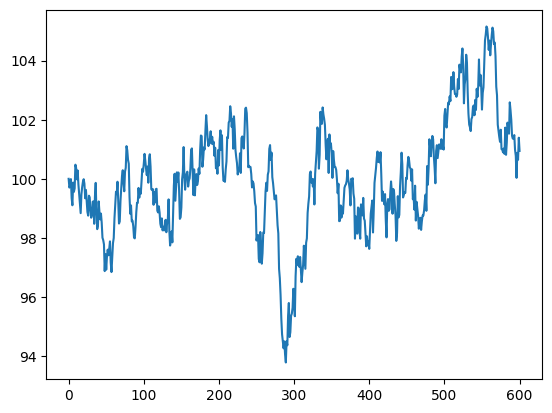

In [14]:
asset_price = df['underlying'].to_numpy()
plt.plot(asset_price)
plt.show()

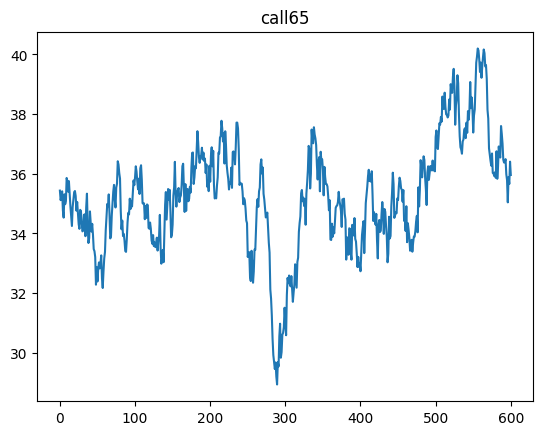

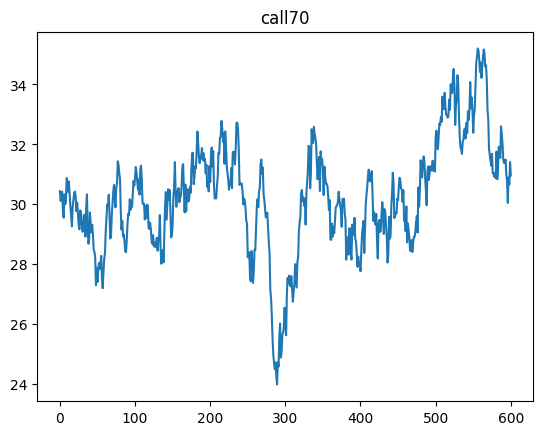

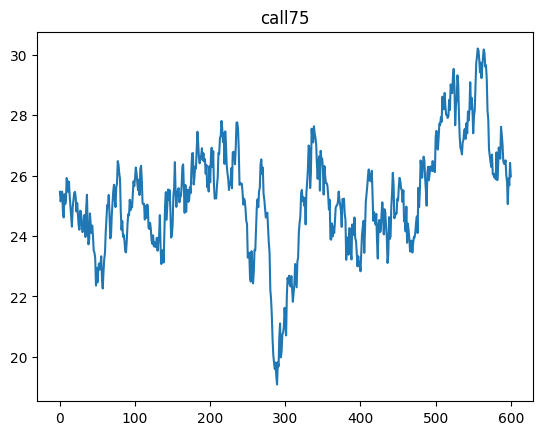

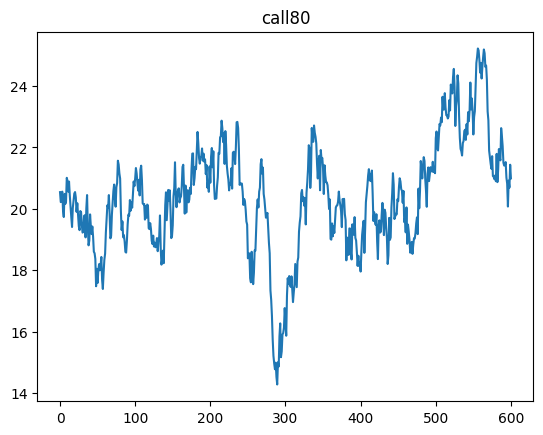

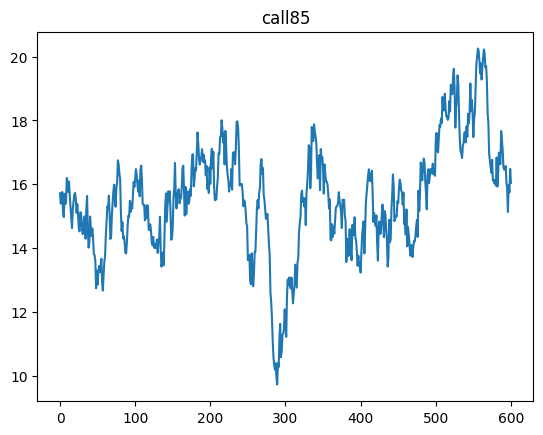

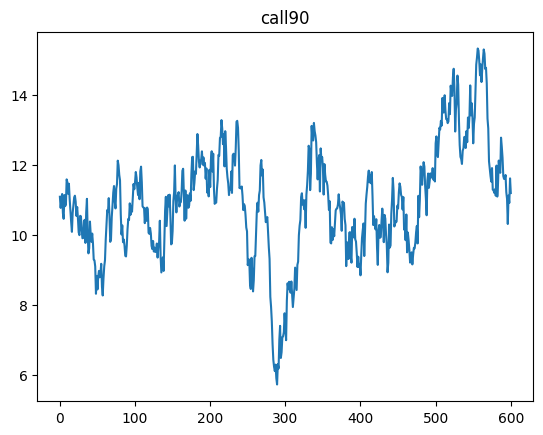

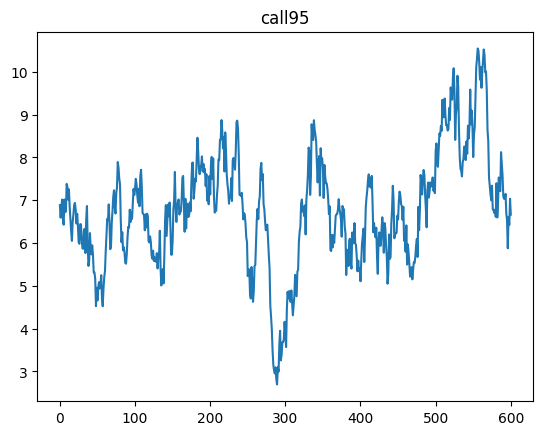

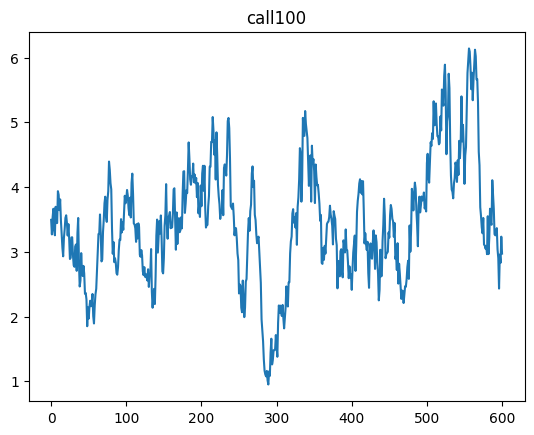

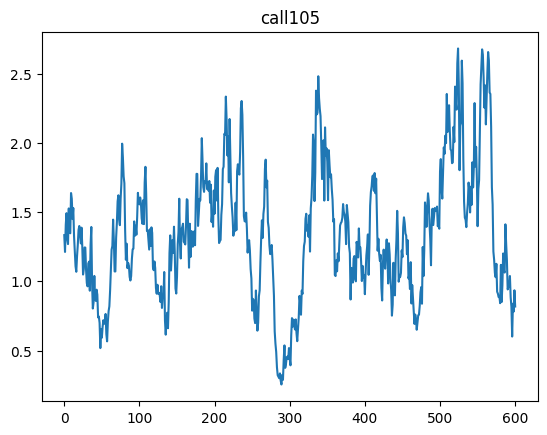

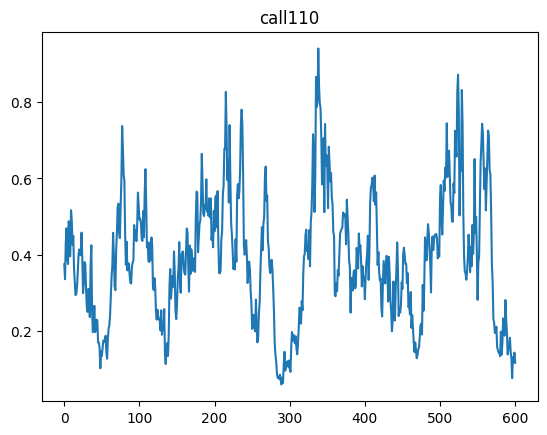

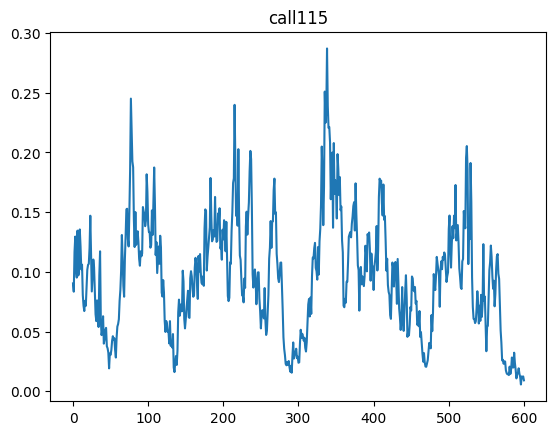

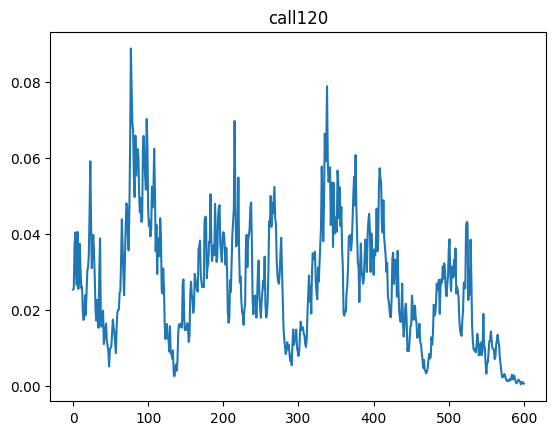

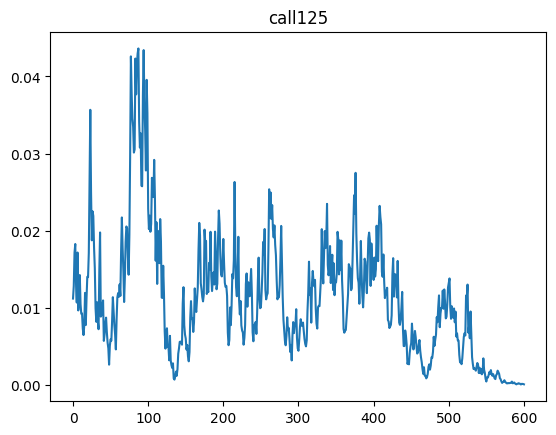

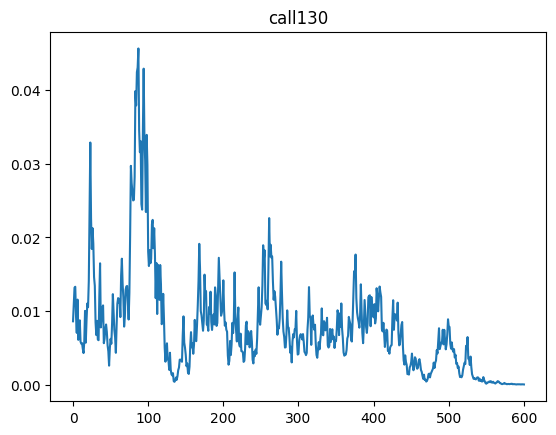

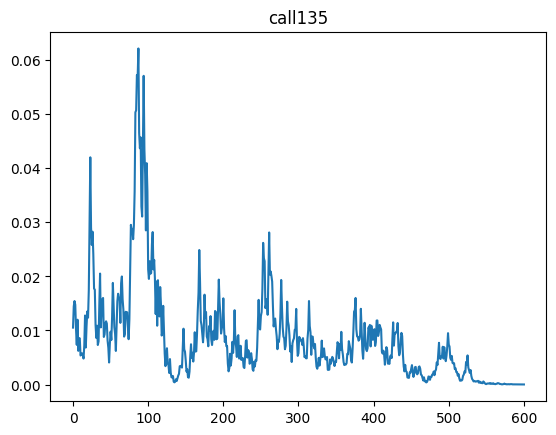

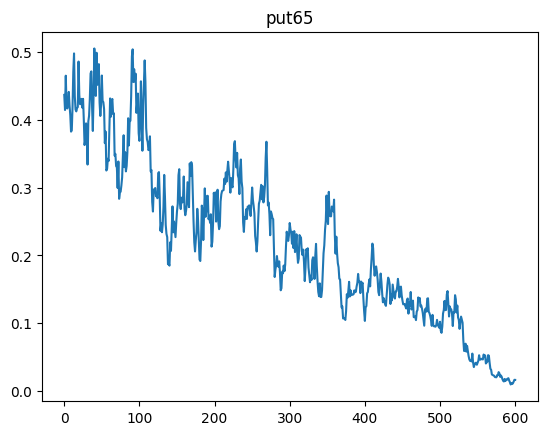

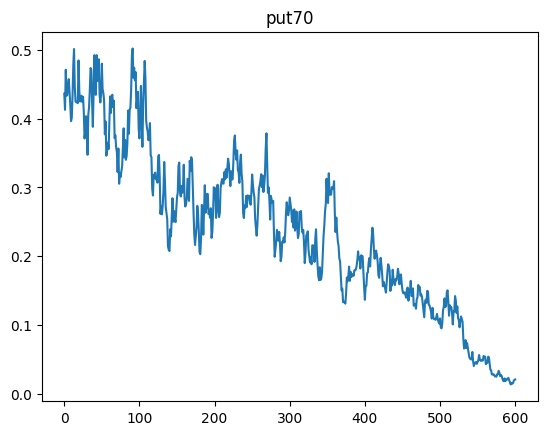

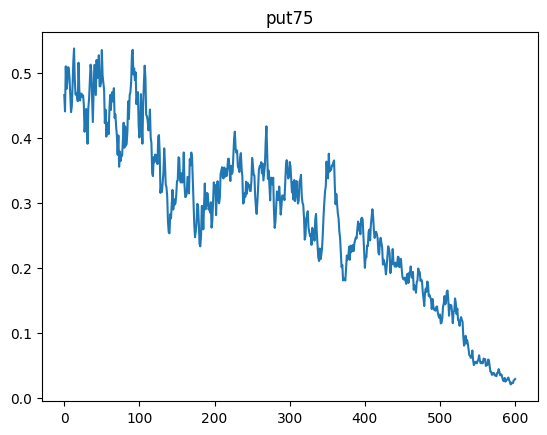

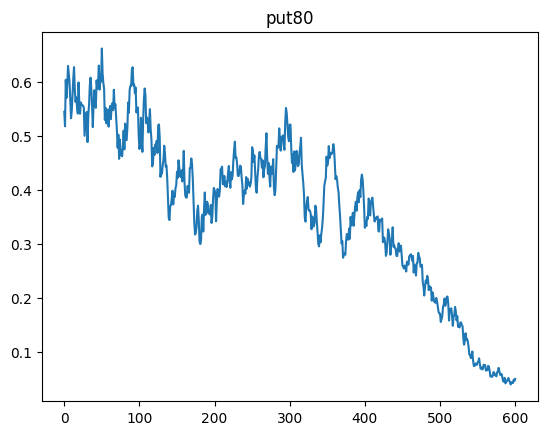

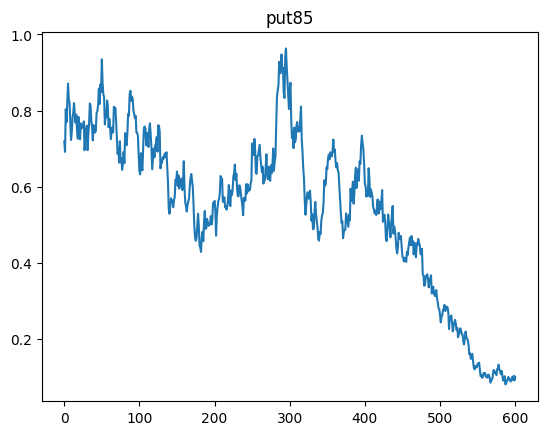

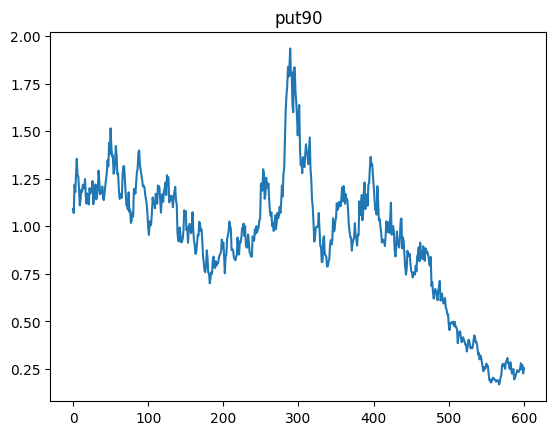

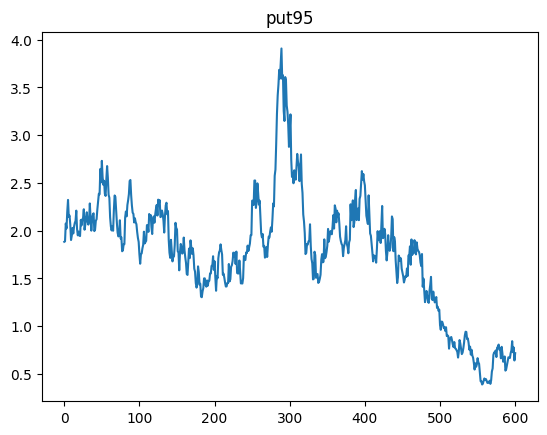

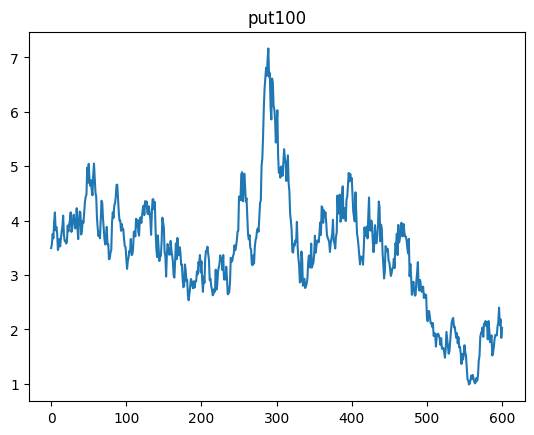

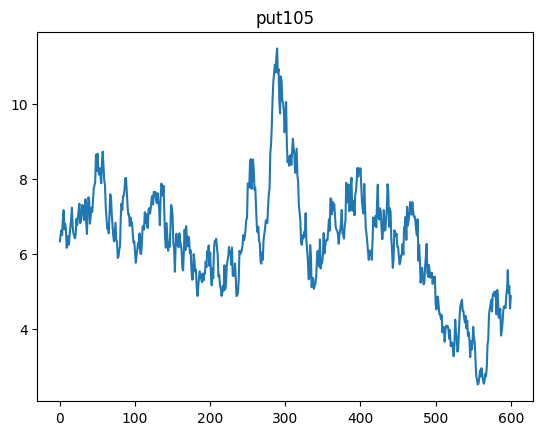

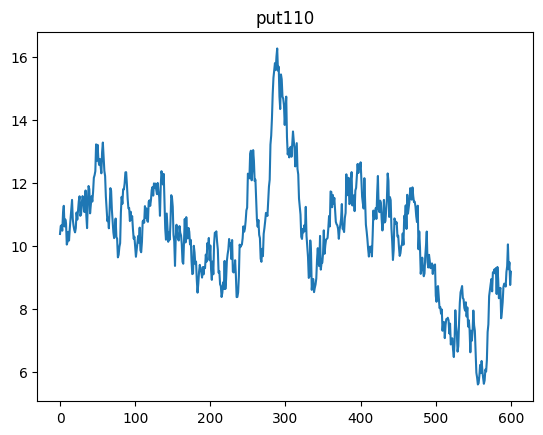

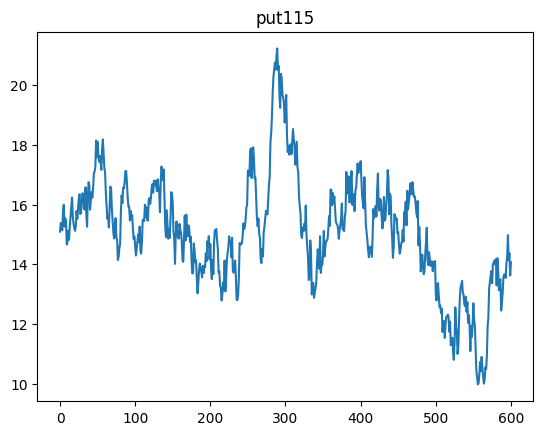

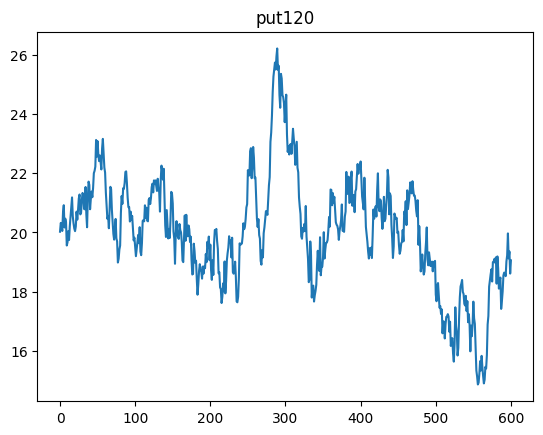

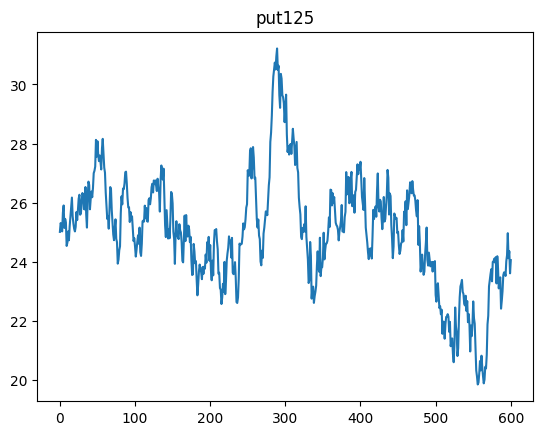

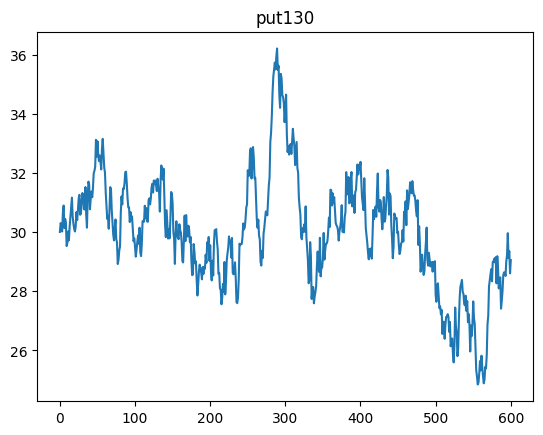

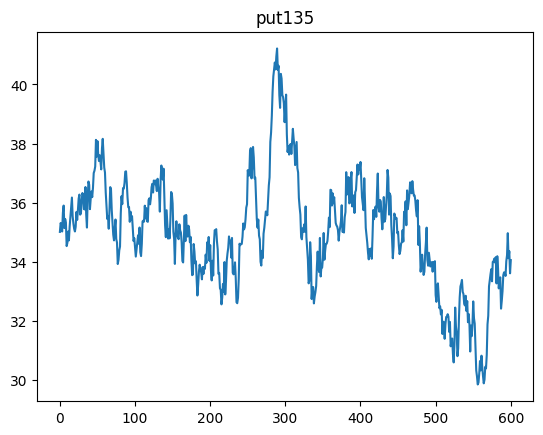

In [26]:
options = df.columns[2:].to_numpy()
for option_name in options:
    option_price = df[option_name].to_numpy()
    
    plt.title(option_name)
    plt.plot(option_price)
    plt.show()
    

/var/folders/bm/t6m4k8r90xxcy1x18tqmww_h0000gn/T/ipykernel_2166/2793826174.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S / K) + (r + sigma**2 / 2) * t)


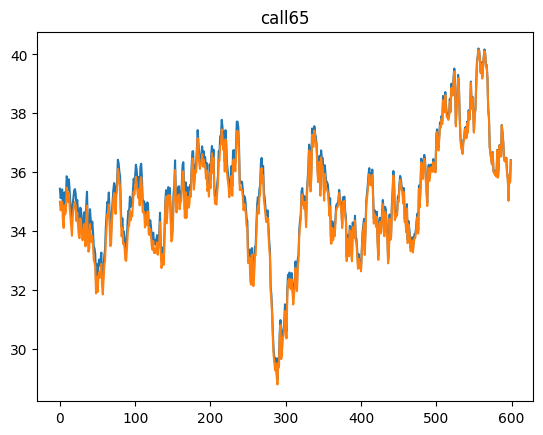

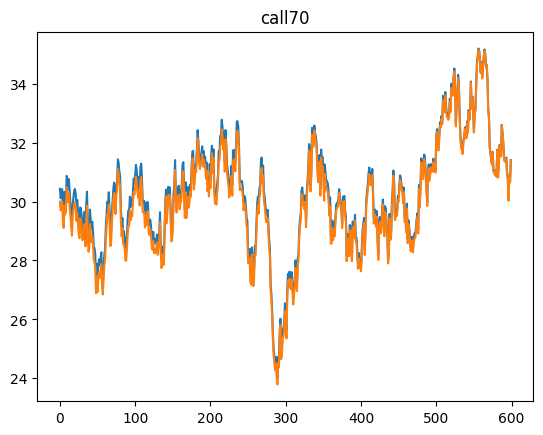

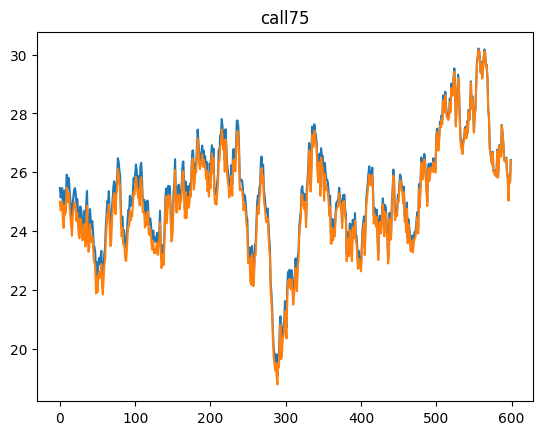

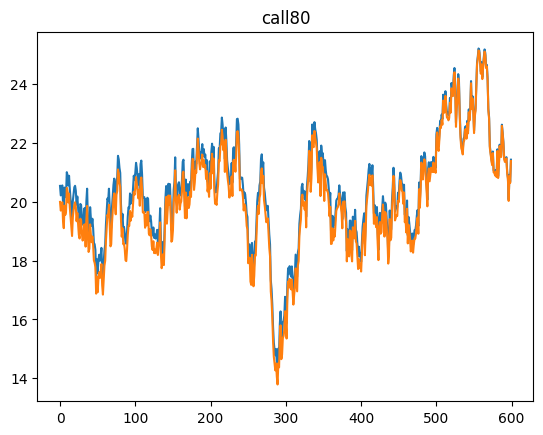

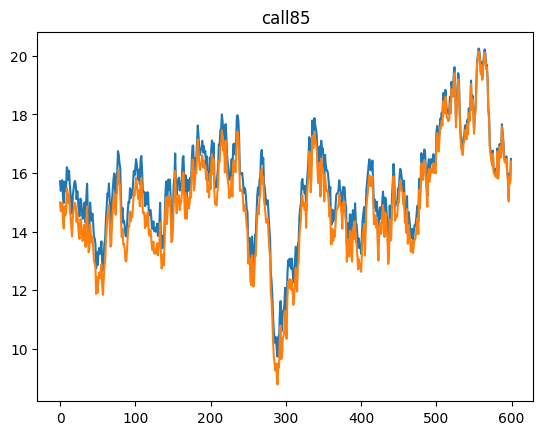

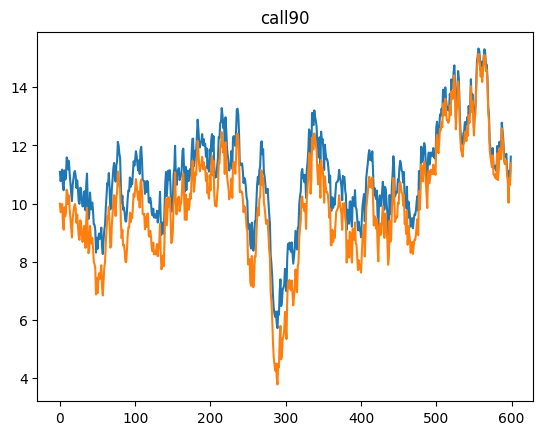

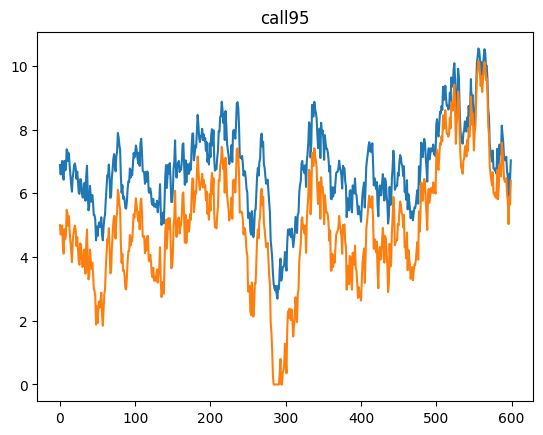

/var/folders/bm/t6m4k8r90xxcy1x18tqmww_h0000gn/T/ipykernel_2166/2793826174.py:2: RuntimeWarning: invalid value encountered in scalar multiply
  d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S / K) + (r + sigma**2 / 2) * t)


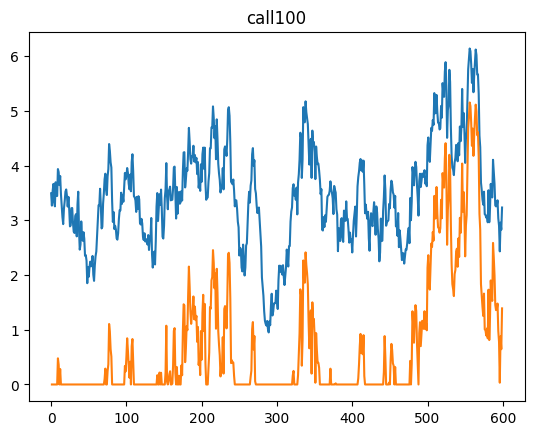

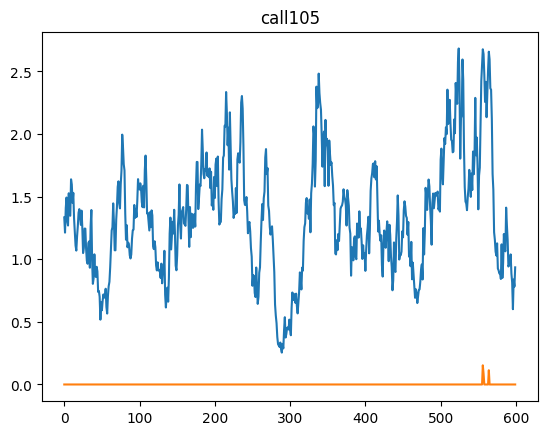

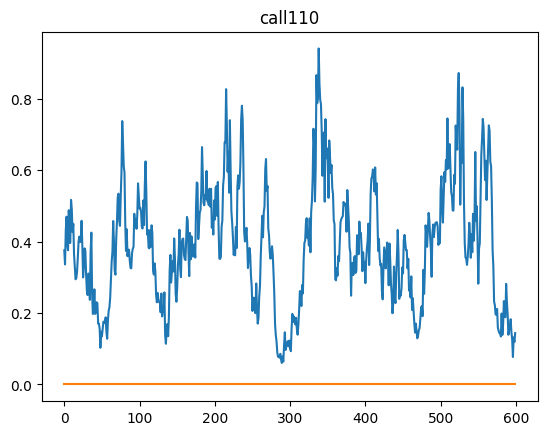

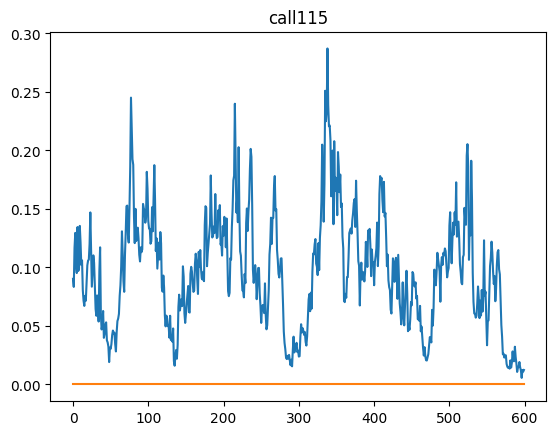

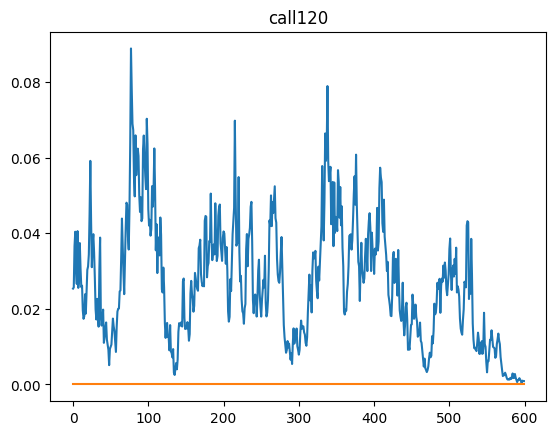

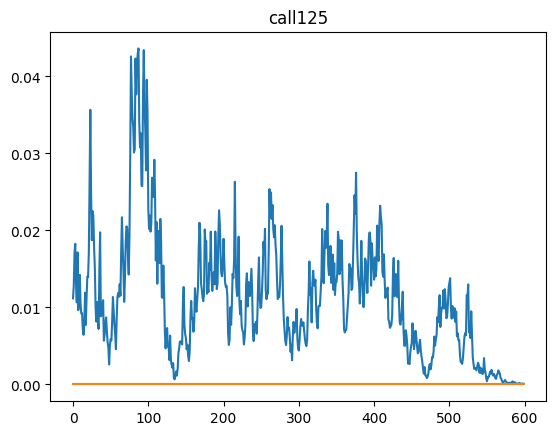

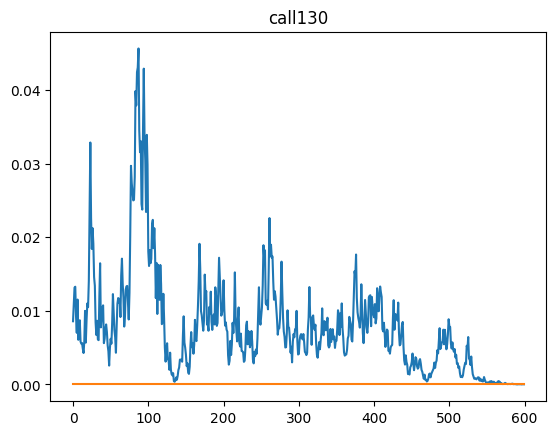

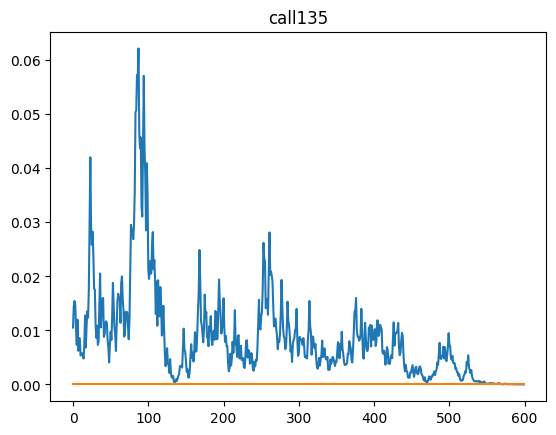

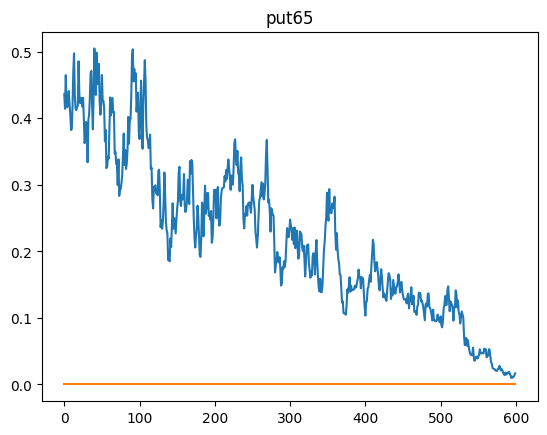

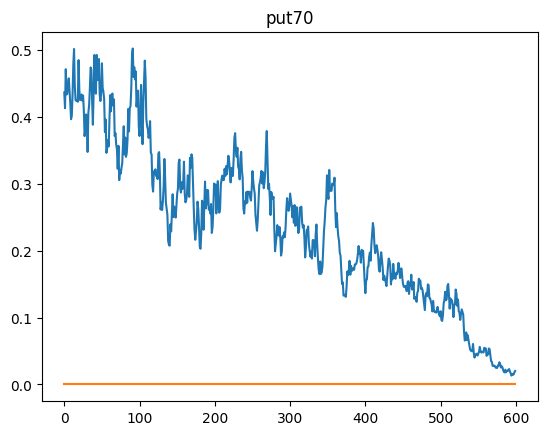

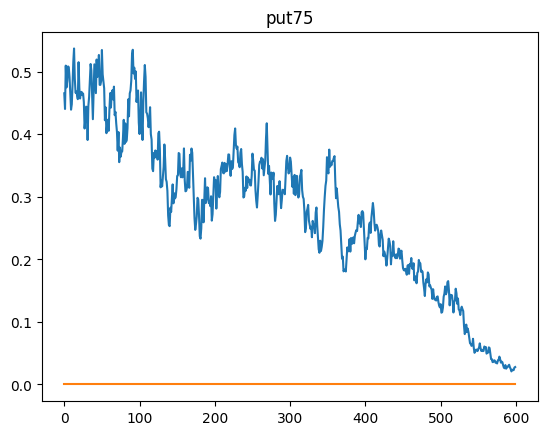

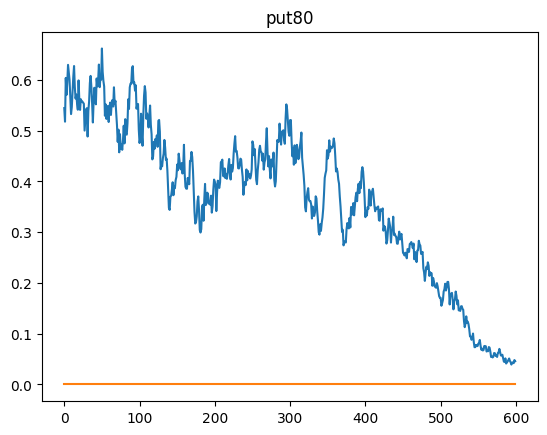

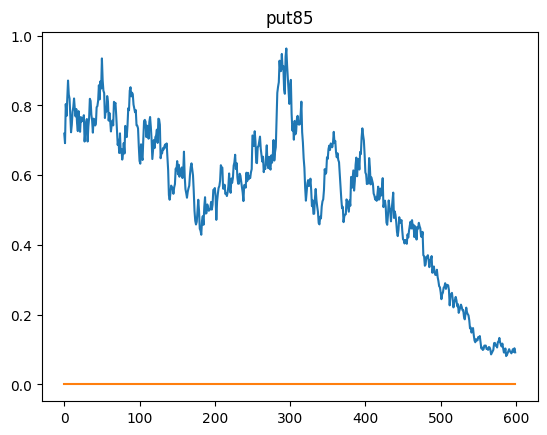

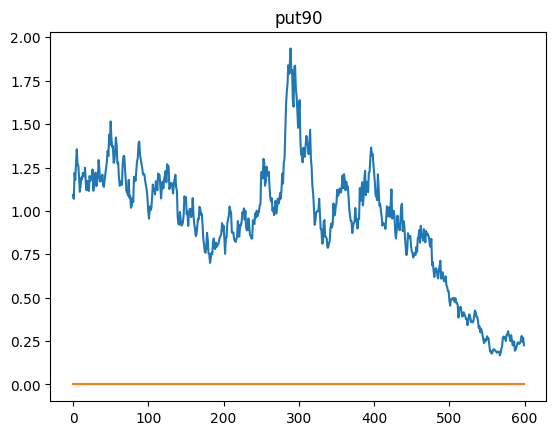

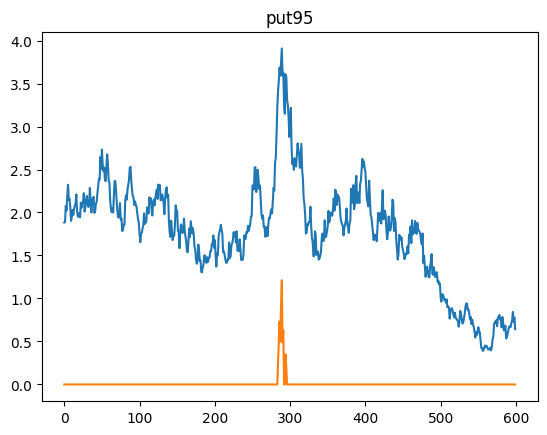

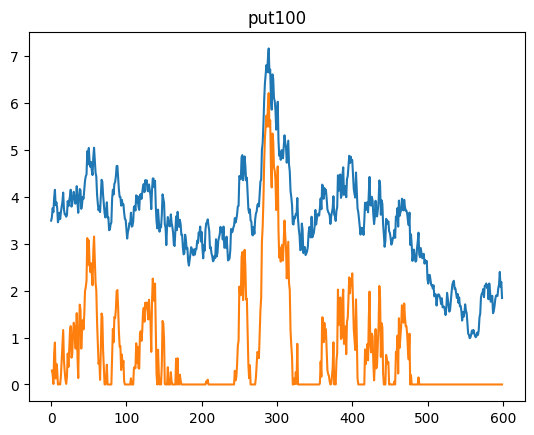

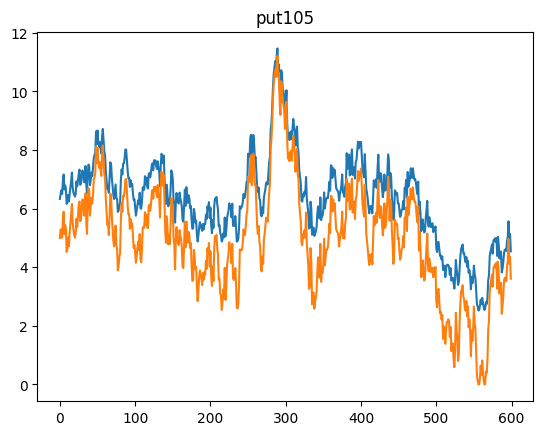

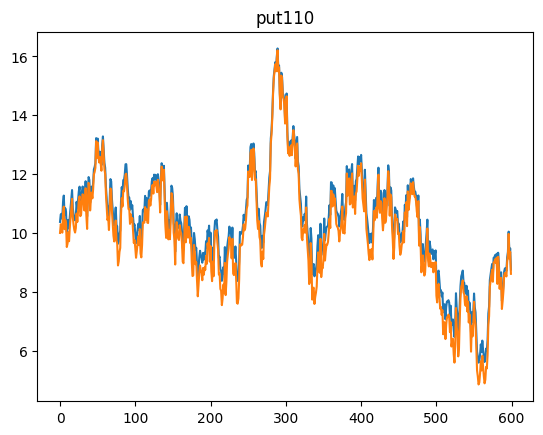

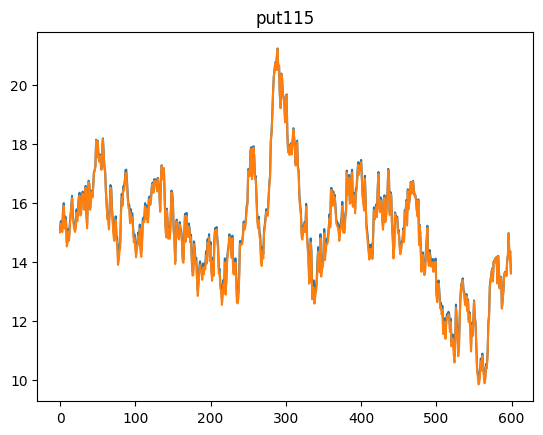

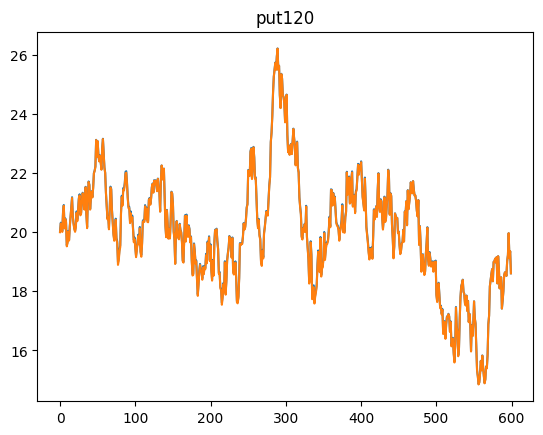

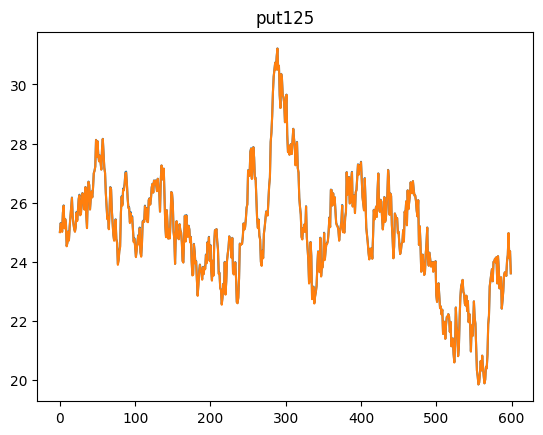

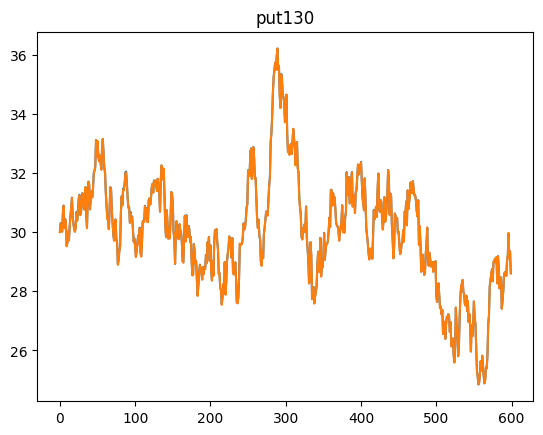

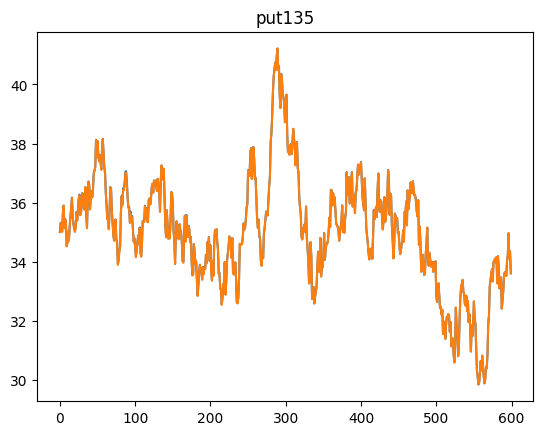

In [56]:
def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S / K) + (r + sigma**2 / 2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return d1, d2

def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * t)
    return C

def put_price(sigma, S, K, r, t, d1, d2):
    P = -norm.cdf(-d1) * S + norm.cdf(-d2) * K * np.exp(-r * t)
    return P

def vega(sigma, S, K, r, t):
    d1, d2 = d(sigma, S, K, r, t)
    v = S * norm.pdf(d1) * np.sqrt(t)
    return v

def delta(d_1, contract_type):
    if contract_type == 'C':
        return norm.cdf(d_1)
    if contract_type == 'P':
        return -norm.cdf(-d_1)
    
def gamma(d2, S, K, sigma, r, t):
    return(K * np.exp(-r * t) * (norm.pdf(d2) / (S**2 * sigma * np.sqrt(t)))) 

def theta(d1, d2, S, K, sigma, r, t, contract_type):
    if contract_type == 'C':
        theta = -S * sigma * norm.pdf(d1) / (2 * np.sqrt(t)) - r * K * np.exp(-r * t) * norm.cdf(d2)
    if contract_type == 'P':
        theta = -S * sigma * norm.pdf(-d1) / (2 * np.sqrt(t)) + r * K * np.exp(-r * t) * norm.cdf(-d2)
    return theta

def implied_vol(sigma, S, K, r, t, bs_price, price):
    val = bs_price - price
    veg = vega(sigma, S, K, r, t)
    vol = -val / veg + sigma
    return vol


time_to_expiry = np.linspace(0.25, 0.0833, 600)

strike_price_list = [65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135]
options = df.columns[2:].to_numpy()
for option_name in options:
    option_price = df[option_name].to_numpy()
    bs_price = np.zeros(600)
    
    Call = True
    strike_price = int(option_name[4:])
    if option_name[0] == 'p':
        Call = False
        strike_price = int(option_name[3:])
    
    
    for timestamp in range(600):
        sigma = np.sqrt((t[timestamp])*365) * ((asset_price[timestamp] - asset_price[timestamp-1]) / asset_price[timestamp-1]).std()
        
        #volatility = implied_vol(sigma, S, K, 0, time_to_expiry[timestamp], bs_price, price)
        volatility = np.sqrt((t[timestamp])*365) * ((asset_price[timestamp] - asset_price[timestamp-1]) / asset_price[timestamp-1]).std() 
        
        
        d1, d2 = d(volatility, asset_price[timestamp], strike_price, 0, time_to_expiry[timestamp])
        
        if Call == True:
            bs_price[timestamp] = call_price(volatility, asset_price[timestamp], strike_price, 0, time_to_expiry[timestamp], d1, d2)            
        else:
            bs_price[timestamp] = put_price(volatility, asset_price[timestamp], strike_price, 0, time_to_expiry[timestamp], d1, d2)
            
            
    plt.title(option_name)
    plt.plot(option_price[:-1])
    plt.plot(bs_price)
    plt.show()
    

